# Finding Lane Lines on the Road
Steps:
1)Test how the image looks like
2)Writing the helper functions using opencv
3)Testing with set of images
4)Testing for video frames
5)Writing the output annotated video


# import packages required

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Read sample image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


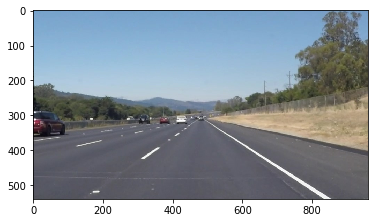

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

# Possible opencv functions which can be used

**Some OpenCV functions used for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



# Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns lane lines.
    """
      # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    
    #Make lists of the lines and slopes for averaging
    left_lines = []
    left_slopes = []
    right_lines = []
    right_slopes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left_lines.append(line)
                left_slopes.append(slope)
            else:
                right_lines.append(line)
                right_slopes.append(slope)
    
    #Average line positions
    avg_left_pos = [sum(col)/len(col) for col in zip(*left_lines)]
    avg_right_pos = [sum(col)/len(col) for col in zip(*right_lines)]
    
    #Remove slope outliers, and take the average
    avg_left_slope = np.mean(remove_outliers(left_slopes))
    avg_right_slope = np.mean(remove_outliers(right_slopes))
    
    #Extrapolate to our mask boundaries - up to 325, down to 539
    avg_left_line = []
    for x1,y1,x2,y2 in avg_left_pos:
        x = int(np.mean([x1, x2])) #Midpoint x
        y = int(np.mean([y1, y2])) #Midpoint y
        slope = avg_left_slope
        b = -(slope * x) + y #Solving y=mx+b for b
        avg_left_line = [int((325-b)/slope), 325, int((539-b)/slope), 539] #Line for the image 
    
    #Same thing for the right side
    avg_right_line = []
    for x1,y1,x2,y2 in avg_right_pos:
        x = int(np.mean([x1, x2]))
        y = int(np.mean([y1, y2]))
        slope = avg_right_slope
        b = -(slope * x) + y
        avg_right_line = [int((325-b)/slope), 325, int((539-b)/slope), 539]
    
    lines = [[avg_left_line], [avg_right_line]]   
    
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Additional function 
Function to take out any super extremes in my below lane_lines function in slopes.

In [4]:
#Removing outlier slopes from the averaging performed below in lane_lines
def remove_outliers(slopes, m = 2):
    med = np.mean(slopes)
    stand_dev = np.std(slopes)
    for slope in slopes:
        if abs(slope - med) > (m * stand_dev):
            slopes.remove(slope)
    return slopes

## Test on Images
**You should make sure your pipeline works well on these images before you try the videos.**

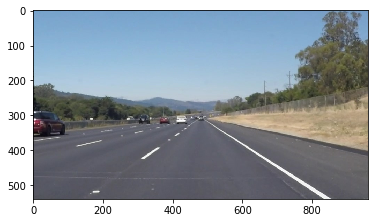

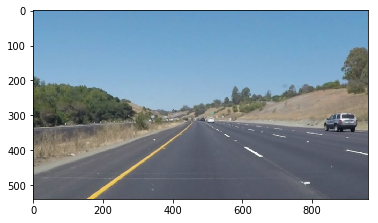

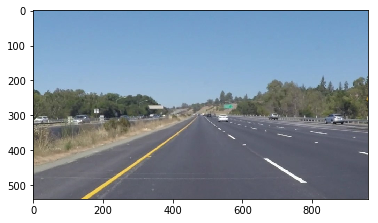

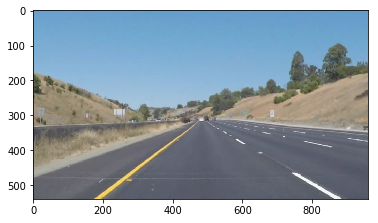

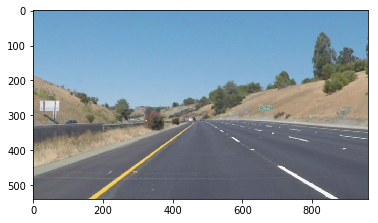

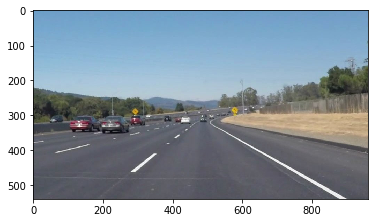

In [5]:
#Importing the images, and let's take a look at what we have!
import os
test_pics = os.listdir("test_images/")

for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(image)
    plt.show()

Run your solution on all test_images and make copies into the test_images directory.

## The pipeline

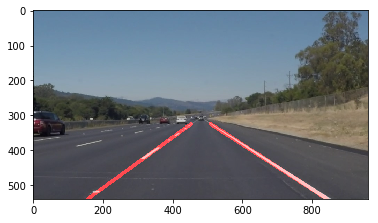

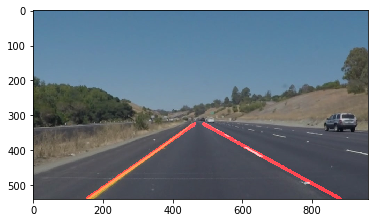

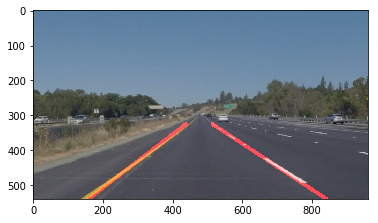

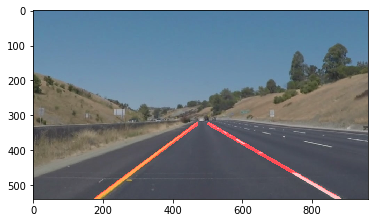

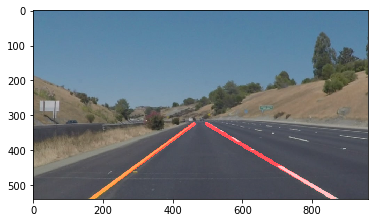

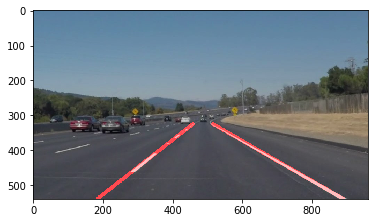

In [6]:
#The below function tries to combine the helper functions as necessary
#Gray-scale, smoothing, canny edge, masking, hough-transform
#Then take the resulting lines and slopes, remove outliers
#Finally, extrapolate the lines based on the average slope and midpoint of the average lane line on each side

def lane_lines(img):
    #Gray-scale it
    gray = grayscale(img)
    #Smooth it a bit with Gaussian Blur
    kernel_size = 9
    blur_gray = gaussian_blur(gray, kernel_size)
    #Add in the canny edge detection
    low_threshold = 90
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)
    # Now the masking
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)  
    masked_edges = region_of_interest(edges, vertices)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/30 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25 #minimum number of pixels making up a line
    max_line_gap = 25    # maximum gap in pixels between connectable line segments
    line_image = np.copy(img)*0 # creating a blank to draw lines on
    lines=hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    draw_lines(line_image, lines)
    # Transparent lines
    line_edges = weighted_img(line_image, img)
    return line_edges

#Pull each image and show it to see how it performed
for i in test_pics: 
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(lane_lines(image))
    plt.show()

## Test on Videos
Test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Process video frames using below function

In [8]:
def process_image(image):
    result = lane_lines(image)
    return result

# Reading frames from video and processing-solidWhiteRight

In [9]:
white_output = 'test_videos_output/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 48.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

CPU times: user 26.7 s, sys: 79.9 ms, total: 26.8 s
Wall time: 4.88 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Reading frames from video and processing-solidWhiteRight

In [11]:
yellow_output = 'test_videos_output/yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/yellow.mp4
[MoviePy] Writing video test_videos_output/yellow.mp4


100%|█████████▉| 681/682 [00:15<00:00, 43.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow.mp4 

CPU times: user 1min 28s, sys: 364 ms, total: 1min 28s
Wall time: 15.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflection
The above code tested for only straight roads. Improvements are possible for more complex scenarios**